In [139]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl
import sklearn as skl

from PIL import Image
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.preprocessing import OneHotEncoder
from test_utils import *

In [140]:
directory = "Dataset/TRY/"
path_example = directory + '0/' + '1.jpg'
image_example = Image.open(path_example)

In [141]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
directory = "Dataset/TRY/"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Found 1057 files belonging to 2 classes.
Using 846 files for training.
Found 1057 files belonging to 2 classes.
Using 211 files for validation.


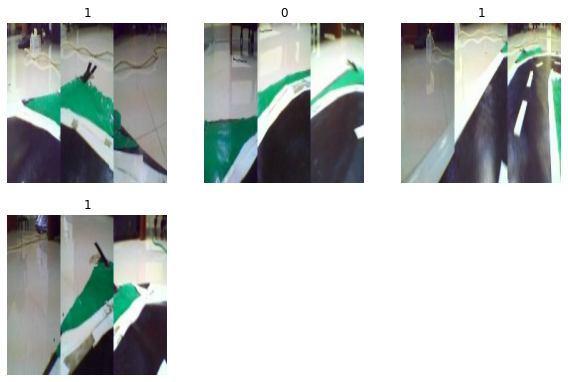

In [142]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(4):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [143]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [144]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

In [145]:
summary(base_model)

[['InputLayer', [(None, 224, 224, 3)], 0],
 ['Conv2D', (None, 112, 112, 32), 864, 'same', 'linear', 'GlorotUniform'],
 ['BatchNormalization', (None, 112, 112, 32), 128],
 ['ReLU', (None, 112, 112, 32), 0],
 ['DepthwiseConv2D', (None, 112, 112, 32), 288],
 ['BatchNormalization', (None, 112, 112, 32), 128],
 ['ReLU', (None, 112, 112, 32), 0],
 ['Conv2D', (None, 112, 112, 16), 512, 'same', 'linear', 'GlorotUniform'],
 ['BatchNormalization', (None, 112, 112, 16), 64],
 ['Conv2D', (None, 112, 112, 96), 1536, 'same', 'linear', 'GlorotUniform'],
 ['BatchNormalization', (None, 112, 112, 96), 384],
 ['ReLU', (None, 112, 112, 96), 0],
 ['ZeroPadding2D', (None, 113, 113, 96), 0, ((0, 1), (0, 1))],
 ['DepthwiseConv2D', (None, 56, 56, 96), 864],
 ['BatchNormalization', (None, 56, 56, 96), 384],
 ['ReLU', (None, 56, 56, 96), 0],
 ['Conv2D', (None, 56, 56, 24), 2304, 'same', 'linear', 'GlorotUniform'],
 ['BatchNormalization', (None, 56, 56, 24), 96],
 ['Conv2D', (None, 56, 56, 144), 3456, 'same', 'li

In [146]:
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers - 2].name)
print(base_model.layers[nb_layers - 1].name)

global_average_pooling2d_16
predictions


In [147]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 1000)


In [148]:
label_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1])>

In [149]:
base_model.trainable = False
image_var = tf.Variable(preprocess_input(image_batch))
pred = base_model(image_var)

tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(), top=2)

[[('n02071294', 'killer_whale', 0.12507747),
  ('n02860847', 'bobsled', 0.1018208)],
 [('n02071294', 'killer_whale', 0.67373496),
  ('n02074367', 'dugong', 0.029378027)],
 [('n03787032', 'mortarboard', 0.3576275),
  ('n04483307', 'trimaran', 0.07253113)],
 [('n04525038', 'velvet', 0.09093769), ('n03041632', 'cleaver', 0.051079135)],
 [('n02071294', 'killer_whale', 0.5649738),
  ('n04483307', 'trimaran', 0.1206551)],
 [('n03697007', 'lumbermill', 0.09352794), ('n03447721', 'gong', 0.061766014)],
 [('n04483307', 'trimaran', 0.18633497),
  ('n02071294', 'killer_whale', 0.1365417)],
 [('n04483307', 'trimaran', 0.44412625),
  ('n02777292', 'balance_beam', 0.058501378)],
 [('n02808440', 'bathtub', 0.13656895),
  ('n04483307', 'trimaran', 0.065177605)],
 [('n04483307', 'trimaran', 0.30322212), ('n04033995', 'quilt', 0.02465256)],
 [('n04336792', 'stretcher', 0.2835711),
  ('n03697007', 'lumbermill', 0.1949477)],
 [('n04483307', 'trimaran', 0.18895654), ('n02879718', 'bow', 0.083294205)],
 [('

In [150]:
def driving_model(image_shape=IMG_SIZE):
    ''' Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''
    
    
    input_shape = image_shape + (3,)
    
    ### START CODE HERE
    
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False, # <== Important!!!!
                                                   weights='imagenet') # From imageNet
    
    # freeze the base model by making it non trainable
    base_model.trainable = False

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) 
    
    # apply data augmentation to the inputs
    #x = data_augmentation(inputs)
    
    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(inputs) 
    
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False) 
    
    # add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tfl.GlobalAveragePooling2D()(x) 
    # include dropout with probability of 0.2 to avoid overfitting
    x = tfl.Dropout(.2)(x)
        
    # use a prediction layer with one neuron (as a binary classifier only needs one)
    outputs = tfl.Dense(1)(x)
    
    #outputs = tfl.Softmax('Softmax')
    
    ### END CODE HERE
    
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [151]:
transfer_model = driving_model(IMG_SIZE)

In [152]:
transfer_model_summary = [['InputLayer', [(None, 160, 160, 3)], 0],
                    ['Sequential', (None, 160, 160, 3), 0],
                    ['TensorFlowOpLayer', [(None, 160, 160, 3)], 0],
                    ['TensorFlowOpLayer', [(None, 160, 160, 3)], 0],
                    ['Functional', (None, 5, 5, 1280), 2257984],
                    ['GlobalAveragePooling2D', (None, 1280), 0],
                    ['Dropout', (None, 1280), 0, 0.2],
                    ['Dense', (None, 1), 1281, 'linear']] #linear is the default activation

for layer in summary(transfer_model):
    print(layer)

['InputLayer', [(None, 224, 224, 3)], 0]
['TFOpLambda', (None, 224, 224, 3), 0]
['TFOpLambda', (None, 224, 224, 3), 0]
['Functional', (None, 7, 7, 1280), 2257984]
['GlobalAveragePooling2D', (None, 1280), 0]
['Dropout', (None, 1280), 0, 0.2]
['Dense', (None, 1), 1281, 'linear']


In [153]:
base_learning_rate = 0.001
transfer_model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [154]:
initial_epochs = 10
history = transfer_model.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/10
27/27 [==============================] - 24s 801ms/step - loss: 0.6600 - accuracy: 0.5946 - val_loss: 0.5709 - val_accuracy: 0.6730
Epoch 2/10
27/27 [==============================] - 25s 926ms/step - loss: 0.5527 - accuracy: 0.6950 - val_loss: 0.5577 - val_accuracy: 0.6588
Epoch 3/10
27/27 [==============================] - 21s 779ms/step - loss: 0.5224 - accuracy: 0.7163 - val_loss: 0.5276 - val_accuracy: 0.7441
Epoch 4/10
27/27 [==============================] - 22s 818ms/step - loss: 0.5177 - accuracy: 0.7104 - val_loss: 0.5178 - val_accuracy: 0.7583
Epoch 5/10
27/27 [==============================] - 21s 794ms/step - loss: 0.4687 - accuracy: 0.7695 - val_loss: 0.5199 - val_accuracy: 0.7014
Epoch 6/10
27/27 [==============================] - 22s 798ms/step - loss: 0.4569 - accuracy: 0.7742 - val_loss: 0.5205 - val_accuracy: 0.7441
Epoch 7/10
27/27 [==============================] - 23s 840ms/step - loss: 0.4386 - accuracy: 0.7825 - val_loss: 0.5204 - val_accuracy: 0.7204

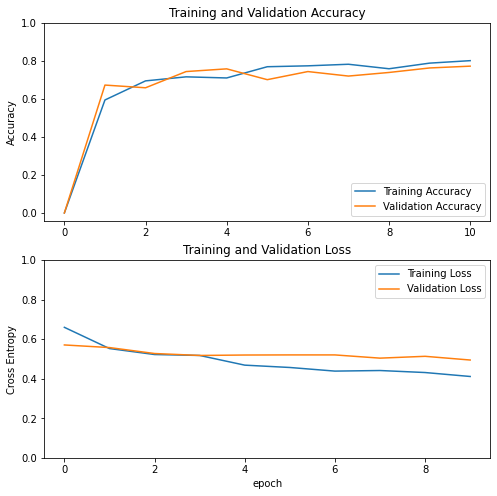

In [155]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [156]:
class_names

['0', '1']

In [157]:
# UNQ_C3
base_model = transfer_model.layers[4]
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 120

### START CODE HERE

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = True
    
# Define a BinaryCrossentropy loss function. Use from_logits=True
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1*base_learning_rate)
# Use accuracy as evaluation metric
metrics = ['accuracy']

### END CODE HERE

transfer_model.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

AttributeError: 'GlobalAveragePooling2D' object has no attribute 'layers'